In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qiime2 import Artifact

from skbio.diversity import beta_diversity, alpha_diversity
from skbio.stats import distance, ordination

from scipy.cluster import hierarchy
from scipy.spatial import distance
from scipy.stats import t, sem

%matplotlib inline

# Read in Data

In [24]:
metadata = pd.read_csv("../metadata/mapping.tsv", sep="\t")

metabo_metadata = metadata.set_index("MetaboSampleID")

## Aqueous metabolome fraction

In [25]:
aqueous = pd.read_csv("../metabolome/Aqueous_Green_Tea_compounds_in_Plasma_020722.txt",
                      sep="\t", header=11, index_col="Compound").T

raw_indexes        = [x for x in list(aqueous.index) if ("Log2(normalized)" not in x)]
normalized_indexes = [x for x in list(aqueous.index) if ("(raw)" not in x)]

raw_aqueous = aqueous.loc[raw_indexes]
log_aqueous = aqueous.loc[normalized_indexes]

raw_aqueous.index = [int(x.split("SBAQ_")[-1][:-5]) if ("SBAQ_" in x)
                     else x 
                     for x in list(raw_aqueous.index)]

log_aqueous.index = [int(x.split("SBAQ_")[-1][:-18]) if ("SBAQ_" in x)
                     else x 
                     for x in list(log_aqueous.index)]

metabo_info_cols = ['Compound Name','Retention Time', 'Measured Retention Time', 
                    'Product Mass','QualifierMass', 'CASNumber', 
                    'CompoundType', 'ISTDCompoundName', 'Mass Column']

raw_aqueous_samples = raw_aqueous.drop(metabo_info_cols).sort_index()
log_aqueous_samples = log_aqueous.drop(metabo_info_cols).sort_index()

## Metabolome lipid fraction

In [26]:
lipid = pd.read_csv("../metabolome/Lipid_Green_Tea_compounds_in_Plasma_020722.txt",
                      sep="\t", header=11, index_col="Compound").T
lipid.head()

raw_lipid_indexes =        [x for x in list(lipid.index) if ("Log2(normalized)" not in x)]
normalized_lipid_indexes = [x for x in list(lipid.index) if ("(raw)" not in x)]

raw_lipid = lipid.loc[raw_lipid_indexes]
log_lipid = lipid.loc[normalized_lipid_indexes]

raw_lipid.index = [int(x.split("Lipid_")[-1][:-5]) if ("Lipid_" in x)
                     else x 
                     for x in list(raw_lipid.index)]

log_lipid.index = [int(x.split("Lipid_")[-1][:-18]) if ("Lipid" in x)
                     else x 
                     for x in list(log_lipid.index)]

raw_lipid_samples = raw_lipid.drop(metabo_info_cols).sort_index()
log_lipid_samples = log_lipid.drop(metabo_info_cols).sort_index()

## Microbiome

In [27]:
microbiome = Artifact.load("../microbiome/tax_filtered_GT.qza").view(pd.DataFrame)

tax = Artifact.load("../microbiome/taxonomy_GT.qza").view(pd.DataFrame)
tax = tax.to_dict()["Taxon"]
microbiome.rename(columns=tax, inplace=True) # map OTUs to taxonomy name

microbiome_mat = np.matrix(microbiome)
microbiome_mat /= microbiome_mat.sum(axis=1) #convert to relative abundances

microbiome = pd.DataFrame(microbiome_mat, columns=microbiome.columns, index=microbiome.index)

# Clustering

In [28]:
def plot_hierarchical_dendrogram(data, metric, linkage_method):
    links = hierarchy.linkage(distance.pdist(data.astype(float), metric=metric),
                              method=linkage_method)
    hierarchy.dendrogram(links)
    ax = plt.gca()
    return links, ax

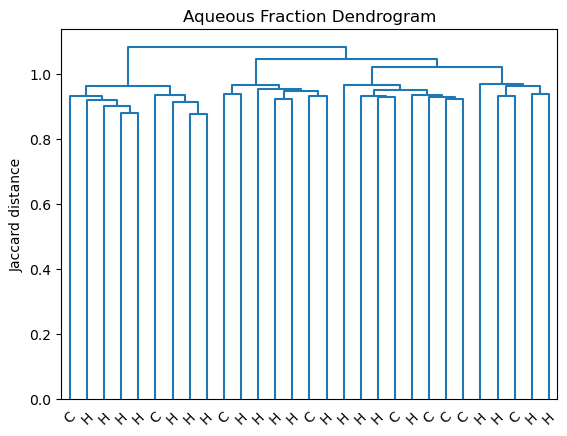

In [29]:
links, ax = plot_hierarchical_dendrogram(raw_aqueous_samples, metric="jaccard", linkage_method="ward")

current_xticks = [tick.get_text() for tick in ax.get_xticklabels()]
new_xticks = np.empty(len(current_xticks), dtype="str")

for i, sampleID in enumerate(current_xticks):
    new_xticks[i] = "Control" if metabo_metadata.loc[int(sampleID)+1, "PID"]=="Control" else "Humanized"
ax.set_xticklabels(new_xticks)

plt.title('Aqueous Fraction Dendrogram')
plt.xlabel('')
plt.ylabel('Jaccard distance')

plt.show()

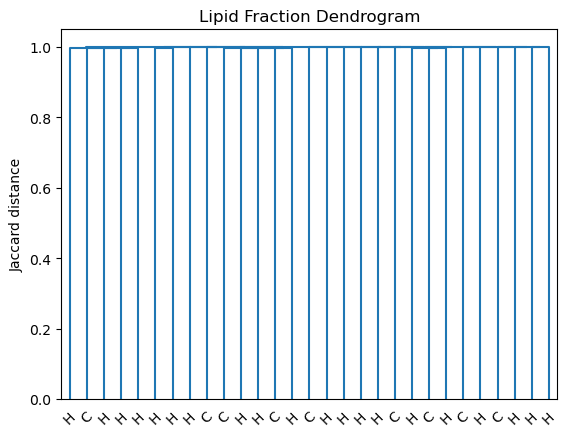

In [30]:
links, ax = plot_hierarchical_dendrogram(raw_lipid_samples, metric="jaccard", linkage_method="complete")

current_xticks = [tick.get_text() for tick in ax.get_xticklabels()]
new_xticks = np.empty(len(current_xticks), dtype="str")

for i, sampleID in enumerate(current_xticks):
    new_xticks[i] = "Control" if metabo_metadata.loc[int(sampleID)+1, "PID"]=="Control" else "Humanized"
ax.set_xticklabels(new_xticks)

plt.title('Lipid Fraction Dendrogram')
plt.xlabel('')
plt.ylabel('Jaccard distance')

plt.show()

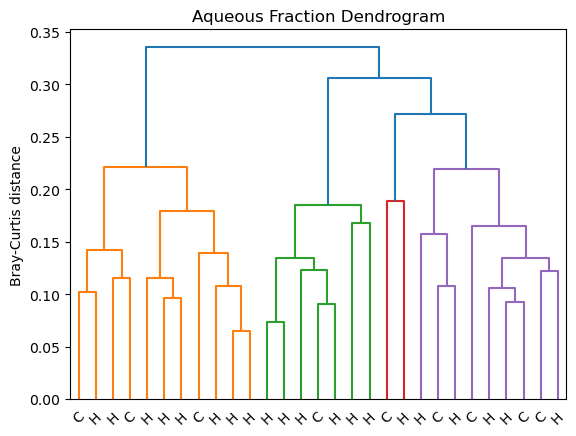

In [31]:
links, ax = plot_hierarchical_dendrogram(raw_aqueous_samples, metric="braycurtis", linkage_method="complete")

current_xticks = [tick.get_text() for tick in ax.get_xticklabels()]
new_xticks = np.empty(len(current_xticks), dtype="str")

for i, sampleID in enumerate(current_xticks):
    new_xticks[i] = "Control" if metabo_metadata.loc[int(sampleID)+1, "PID"]=="Control" else "Humanized"
ax.set_xticklabels(new_xticks)

plt.title('Aqueous Fraction Dendrogram')
plt.xlabel('')
plt.ylabel('Bray-Curtis distance')

plt.show()

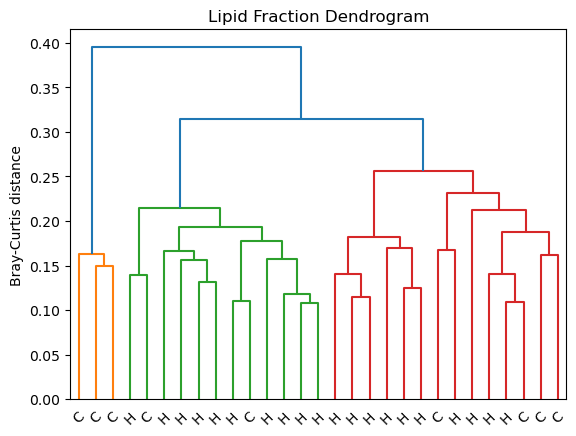

In [32]:
links, ax = plot_hierarchical_dendrogram(raw_lipid_samples, metric="braycurtis", linkage_method="complete")

current_xticks = [tick.get_text() for tick in ax.get_xticklabels()]
new_xticks = np.empty(len(current_xticks), dtype="str")

for i, sampleID in enumerate(current_xticks):
    new_xticks[i] = "Control" if metabo_metadata.loc[int(sampleID)+1, "PID"]=="Control" else "Humanized"
ax.set_xticklabels(new_xticks)

plt.title('Lipid Fraction Dendrogram')
plt.xlabel('')
plt.ylabel('Bray-Curtis distance')

plt.show()

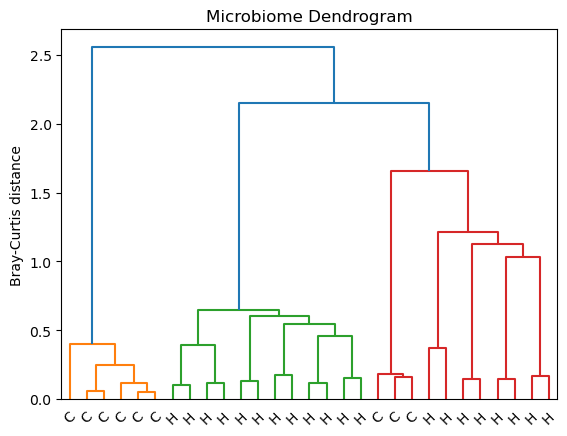

In [33]:
links, ax = plot_hierarchical_dendrogram(microbiome, metric="braycurtis", linkage_method="ward")

current_xticks = [tick.get_text() for tick in ax.get_xticklabels()]
new_xticks = np.empty(len(current_xticks), dtype="str")

for i, sampleID in enumerate(current_xticks):
    new_xticks[i] = "Control" if metadata.iloc[int(sampleID)]["PID"]=="Control" else "Humanized"
ax.set_xticklabels(new_xticks)

plt.title('Microbiome Dendrogram')
plt.xlabel('')
plt.ylabel('Bray-Curtis distance')

plt.show()

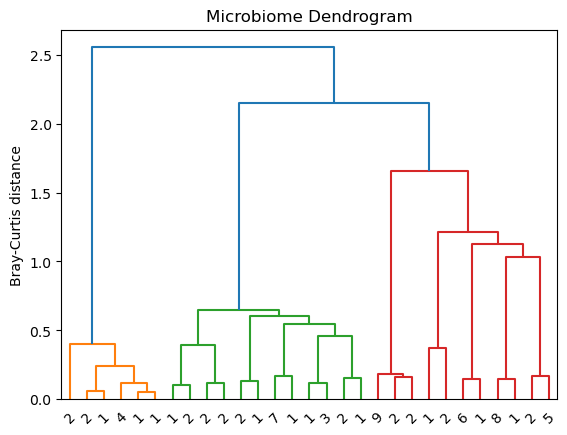

In [34]:
links, ax = plot_hierarchical_dendrogram(microbiome, metric="braycurtis", linkage_method="ward")

current_xticks = [tick.get_text() for tick in ax.get_xticklabels()]
new_xticks = np.empty(len(current_xticks), dtype="str")

for i, sampleID in enumerate(current_xticks):
    new_xticks[i] = metadata.iloc[int(sampleID)]["MetaboSampleID"]
ax.set_xticklabels(new_xticks)

plt.title('Microbiome Dendrogram')
plt.xlabel('')
plt.ylabel('Bray-Curtis distance')

plt.show()

## Quantify Jaccard distance

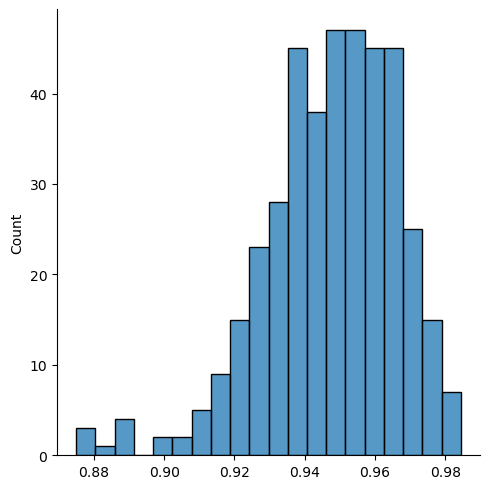

In [41]:
raw_aqueous_jaccards = distance.pdist(raw_aqueous_samples, metric="jaccard")
sns.displot(raw_aqueous_jaccards)

In [48]:
CI = t.interval(alpha=0.95, 
           df=len(raw_aqueous_jaccards)-1, 
           loc=np.mean(raw_aqueous_jaccards), 
           scale=sem(raw_aqueous_jaccards)) 

print(f"Mean {np.mean(raw_aqueous_jaccards)}")
print(f"95% CI - {CI}")

print(f"Max {max(raw_aqueous_jaccards)}")

print(f"Min {min(raw_aqueous_jaccards)}")

Mean 0.9465440270935961
95% CI - (0.9447782084617554, 0.9483098457254368)
Max 0.984375
Min 0.875


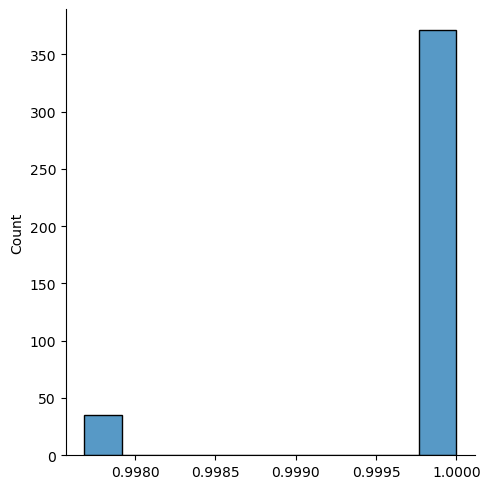

In [40]:
sns.displot(distance.pdist(raw_lipid_samples, metric="jaccard"))

In [49]:
raw_lipid_jaccards = distance.pdist(raw_lipid_samples, metric="jaccard")

CI = t.interval(alpha=0.95, 
           df=len(raw_lipid_jaccards)-1, 
           loc=np.mean(raw_lipid_jaccards), 
           scale=sem(raw_lipid_jaccards)) 

print(f"Mean {np.mean(raw_lipid_jaccards)}")
print(f"95% CI - {CI}")

print(f"Max {max(raw_lipid_jaccards)}")

print(f"Min {min(raw_lipid_jaccards)}")

Mean 0.9998004469987228
95% CI - (0.9997369823963547, 0.999863911601091)
Max 1.0
Min 0.9976851851851852
